## EM for MLE and MAP

### The Target Distribution
Recall that in our model, we suppose that our data, $\mathbf{X}=\{\mathbf{x}_1, \ldots, \mathbf{x}_K\}$ is drawn from the mixture of $K$ number of Gaussian distributions. For each observation $\mathbf{x}_n$ we have a latent variable $\mathbf{z}_n$ that is a 1-of-$K$ binary vector with elements $z_{nk}$. We denote the set of latent variable by $\mathbf{Z}$. Recall that the distibution of $\mathbf{Z}$ given the mixing coefficients, $\pi$, is given by
\begin{align}
p(\mathbf{Z} | \pi) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} 
\end{align}
Recall also that the likelihood of the data is given by,
\begin{align}
p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) =\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left(\mathbf{x}_n| \mu_k, \Sigma_k\right)^{z_{nk}}
\end{align}
Finally, in our basic model, we choose a Dirichlet prior for $\pi$ 
\begin{align}
p(\pi) = \mathrm{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^K \pi_k^{\alpha_0 -1},
\end{align}
where $C(\alpha_0)$ is the normalizing constant for the Dirichlet distribution. We also choose a Normal-Inverse-Wishart prior for the mean and the covariance of the likelihood function
\begin{align}
p(\mu, \Sigma) = p(\mu | \Sigma) p(\Sigma) = \prod_{k=1}^K \mathcal{N}\left(\mu_k | \mathbf{m}_0, \mathbf{V}_0\right) IW(\Sigma_k|\mathbf{S}_0, \nu_0).
\end{align}
Thus, the joint distribution of all the random variable is given by
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \pi, \mu, \Sigma) = p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) p(\mathbf{Z} | \pi) p(\pi) p(\mu | \Sigma) p(\Sigma)
\end{align}

### EM for MLE

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k}{N},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\mu_k &=\frac{\sum_{n=1}^N r_{nk}\mathbf{x}_n}{r_k}\\
\Sigma_k &= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n\mathbf{x}_n^\top}{r_k} - \mu_k\mu_k^\top
\end{align}

### EM for MAP

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k + \alpha_k - 1}{N + \sum_{k=1}^K \alpha_k - K},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\hat{\mu}_k &=\frac{r_k \overline{\mathbf{x}}_k + \beta_0 \mathrm{m}_0}{r_k + \beta_0}\\
\overline{\mathbf{x}}_k&= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{r_k}\\
\hat{\Sigma}_k &= \frac{\mathbf{S}_0 + \mathbf{S}_k + \frac{\beta_0r_k}{\beta_0 + r_k}(\overline{\mathbf{x}}_k - \mathbf{m}_0)(\overline{\mathbf{x}}_k - \mathbf{m}_0)^\top}{\nu_0 + r_k + D + 2}\\
\mathbf{S}_k &= \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \overline{\mathbf{x}}_k)(\mathbf{x}_n - \overline{\mathbf{x}}_k)^\top
\end{align}


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
from scipy.stats import gaussian_kde
from scipy.interpolate import spline
from scipy.io import loadmat, savemat
import pandas as pd
import pymc as pm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal as MVN

import re
import numpy as np

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#------------------    Read in and Process Real Data    ----------------------#
# Read 311 data
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv')
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)

# Filter for closed cases
t1 = time.time()
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
t2 = time.time()
print "Filtered data in %.2f seconds." % (t2 - t1)

# Convert dates to datetime type
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    closed_requests[col] = pd.to_datetime(closed_requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2 - t1)

Read in data in 8.58 seconds.
Filtered data in 0.28 seconds.

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Dates processed in 943.06 seconds.


## I. Methods

### Data Generation

In [122]:
########################################
########################################
#####        Make real data        #####
########################################
########################################

def real_data(begin_date, end_date, source, landmark_date, reason=None, dept=None, random=None):
    begin = pd.to_datetime(begin_date) 
    end = pd.to_datetime(end_date)
    
    # Filter for requests opened between begin and end dates
    in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
    in_range = in_range[in_range['OPEN_DT'] < end]
    
    # Filter for requests with specific source
    in_range = in_range[in_range['Source'] == source]
    
    # Filter by reason
    if reason is not None:
        in_range = in_range[in_range['REASON'] == reason]
        
    # Filter by department
    if dept is not None:
        in_range = in_range[in_range['Department'] == dept]
        
    # Shuffle
    if random is not None:
        in_range.reindex(np.random.permutation(in_range.index))
        
    # Compute response time for filtered requests
    elapsed_time = in_range['CLOSED_DT'].values - in_range[landmark_date].values
    elapsed_time = elapsed_time.astype('timedelta64[m]').astype('float64')
    
    
    
    # Data is a (N x 3) matrix with features: response time, longitude, latitude, case ID
    data = np.hstack((elapsed_time.reshape((len(in_range), 1)), 
                      in_range['LONGITUDE'].values.reshape((len(in_range), 1)), 
                      in_range['LATITUDE'].values.reshape((len(in_range), 1)), 
                      in_range['CASE_ENQUIRY_ID'].values.reshape((len(in_range), 1))))
    return data

########################################
########################################
#####       Makes test data        #####
########################################
########################################

def test_data(N, D, K, offset=1):
    n_samples = int(N/K) #number of points in each component
    mu = np.array([[k * offset] * D for k in xrange(K)]) #mu's

    # generate random sample, two components
    np.random.seed(0)

    # generate spherical data centered on mu's
    comps = [np.random.randn(n_samples, D) + mu[k, :] for k in xrange(K)] 

    # concatenate the two datasets into training set
    data = np.vstack(comps)

    #plot the components
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    values = np.linspace(0, 1, K)
    cm = plt.get_cmap('rainbow') 
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    for k in xrange(K):
        colorVal = scalarMap.to_rgba(values[k])
        ax.scatter(comps[k][:, 0], comps[k][:, 1], comps[k][:, 2], c=colorVal)

    plt.title('test data')
    plt.show()
    
    return data

### Clustering

In [6]:
########################################
########################################
###   K-means init for mu and Sigma  ###
########################################
########################################

def k_means(N, D, K, X):
    kmeans = KMeans(init='random', n_clusters=K) #k-means++
    kmeans.fit(data)
    mu = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    
    clusters = [labels[labels == k].shape[0] for k in xrange(K)]    
    pi = np.array([clusters[k] / (1. * sum(clusters)) for k in xrange(K)])
    
    clusters = [[X[n] for n in xrange(N) if labels[n] == k] for k in xrange(K)]
    
    Sigma = []
    for k in xrange(K):
        Sigma_k = np.zeros((D, D))
        for pt in clusters[k]:
            Sigma_k += np.outer(pt, pt)
        Sigma.append(Sigma_k - len(clusters[k]) * np.outer(mu[k], mu[k]))
        
    return pi, mu, Sigma

########################################
########################################
#####       Plot clusters          #####
########################################
########################################
def plot_clusters(data_std, r, K, title):
    
    for n in xrange(N):
        r_n = r[n, :]
        r_n[r_n < np.max(r_n)] = 0
        r_n[r_n == np.max(r_n)] = 1
        r[n, :] = r_n
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    clusters = [np.asarray([data_std[n] for n in xrange(N) if r[n, k] == 1]) for k in xrange(K)]

    values = np.linspace(0, 1, K)
    cm = plt.get_cmap('rainbow') 
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    for k in xrange(K):    
        colorVal = scalarMap.to_rgba(values[k])
        if len(clusters[k]) > 0:
            ax.scatter(clusters[k][:, 0], clusters[k][:, 1], clusters[k][:, 2], c=colorVal)
   
    plt.title(title)
    plt.show()

### Inference

In [8]:
########################################
########################################
#####         EM for MLE           #####
########################################
########################################

def MLE_EM(K, D, N, X, pi_0, mu_0, Sigma_0, iters, diag=None):
    
    #initialization of parameters    
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    
    llkhds = []
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k])
        return np.nan_to_num(prob)
    
    #---------------- Log Likelihood ----------------#    
    def llkhd(pi, mu, Sigma):
        prob = lkhd(pi, mu, Sigma) 
        prob = np.log(np.sum(prob, axis=1))
        prob = np.sum(prob, axis=0)
        return prob
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.nan_to_num(np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob))
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = 1. / N * r_ks
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        
        Sigma_new = []
        for k in xrange(K):
            Sigma_k = np.zeros((D, D))
            for n in xrange(N):
                Sigma_k += r[n, k] * np.outer(X[n, :] - mu[k, :], X[n, :] - mu[k, :])
            Sigma_new.append(np.nan_to_num(Sigma_k / r_ks[k]))
            
        return pi_new, mu_new, Sigma_new
    
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters): 
        llkhds.append(np.nan_to_num(llkhd(pi, mu, Sigma)))
        r = E_step()
        pi, mu, Sigma = M_step()
        
    r = E_step()
    
    if diag is not None:
        plt.plot(range(len(llkhds)), llkhds, color='b')
        plt.title('Log Likelihoods for MLE Estimate')
        plt.show()
    
    return pi, mu, Sigma, r

########################################
########################################
#####         EM for MAP           #####
########################################
########################################

def MAP_EM(K, D, N, X, pi_0, mu_0, Sigma_0, S_0, m_0, nu_0, beta_0, alpha_0, iters, diag=None):
    
    #initialization of intermediate parameters
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    S = [np.eye(D) for k in xrange(K)] #(K x K) scatter matrices
    X_mean = mu_0 #mean of pts in each cluster (K x D) matrix
    
    llkhds = []
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k]) 
        return prob
    
    #---------------- Log Likelihood ----------------#    
    def llkhd(pi, mu, Sigma):
        prob = lkhd(pi, mu, Sigma) 
        prob = np.log(np.sum(prob, axis=1))
        prob = np.sum(prob, axis=0)
        return prob
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob)
        
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = (r_ks + alpha_0 - 1) * 1. / (N + np.sum(alpha_0) - K)
        X_mean_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks 
                                                     + beta_0)).dot(np.diag(r_ks).dot(X_mean) 
                                                                    + beta_0 * m_0))
        S_new = []
        Sigma_new = []
        for k in xrange(K):            
            c_1 = (beta_0 * r_ks[k]) / (beta_0 + r_ks[k])
            c_2 = nu_0 + r_ks[k] + D + 2
            Sigma_k = np.nan_to_num(S_0 + S[k] + c_1 
                                    * np.outer(X_mean[k, :] - m_0, X_mean[k, :] - m_0))
            Sigma_new.append(Sigma_k * 1./c_2)
            
            S_k = np.zeros((D, D))
            for n in xrange(N):
                S_k += r[n, k] * np.outer(X[n, :] - X_mean[k, :], X[n, :] - X_mean[k, :])
                
            S_new.append(S_k)
        return pi_new, X_mean_new, mu_new, S_new, Sigma_new
        
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters): 
        llkhds.append(np.nan_to_num(llkhd(pi, mu, Sigma)))
        r = np.nan_to_num(E_step())
        pi, X_mean, mu, S, Sigma = M_step()
    
    r = E_step()
    
    if diag is not None:
        plt.plot(range(len(llkhds)), llkhds, color='b')
        plt.title('Log Likelihoods for MAP Estimate')
        plt.show()
    return pi, X_mean, mu, S, Sigma, r

### Model Selection

The log-likelihood:
\begin{align}
-2\log\mathcal{L}(\mu, \Sigma, \pi | 
\end{align}

In [75]:
########################################
########################################
###    Bayes Information Criterion   ###
########################################
########################################

def bic(N, D, K, X, pi, mu, Sigma):
    #---------------- Likelihood ----------------#    
    def llkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k]) 
        prob = np.log(np.sum(prob, axis=1))
        prob = np.sum(prob, axis=0)
        return prob
    
    bic_score = llkhd(pi, mu, Sigma) - 0.5 * K * D * np.log(N)
    return np.nan_to_num(bic_score)

## II. Tests on Synthetic Data

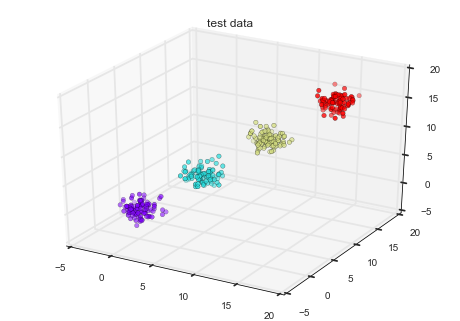

******************* K-means
mixture: [ 0.25  0.25  0.25  0.25]
mu [[  4.96347688   4.84057157   4.78365964]
 [  0.10052051   0.10625231  -0.12418409]
 [ 15.00336493  15.22770189  15.12497281]
 [  9.9396646    9.8216766    9.95191076]]
Sigma: [[ 101.74599469   -2.72112096    5.81740446]
 [  -2.72112096  104.75502604   -4.11658019]
 [   5.81740446   -4.11658019   91.51748555]]
Sigma: [[ 105.27460473   -7.48591402   11.15469897]
 [  -7.48591402   96.43762553   -2.19761951]
 [  11.15469897   -2.19761951   95.25450697]]


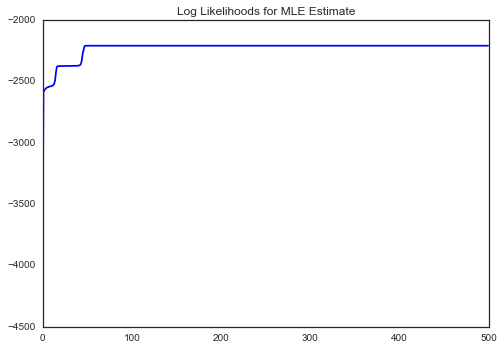

******************* MLE
mixture: [ 0.25000009  0.24999991  0.25        0.25      ]
mu [[  4.96347574   4.84057031   4.78365853]
 [  0.10051983   0.10625179  -0.12418483]
 [ 15.00336493  15.22770189  15.12497281]
 [  9.93966459   9.82167659   9.95191075]]
Sigma: [[ 1.01746307 -0.02720737  0.05817738]
 [-0.02720737  1.04755407 -0.04116211]
 [ 0.05817738 -0.04116211  0.91517774]]
Sigma: [[ 1.05274521 -0.07486011  0.11154569]
 [-0.07486011  0.9643759  -0.02197722]
 [ 0.11154569 -0.02197722  0.95254397]]


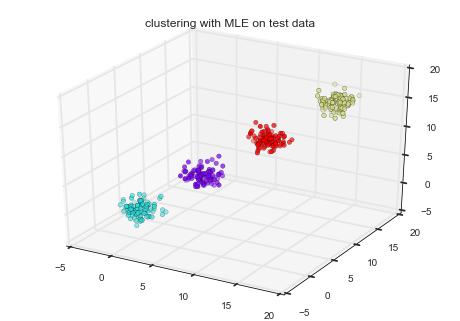

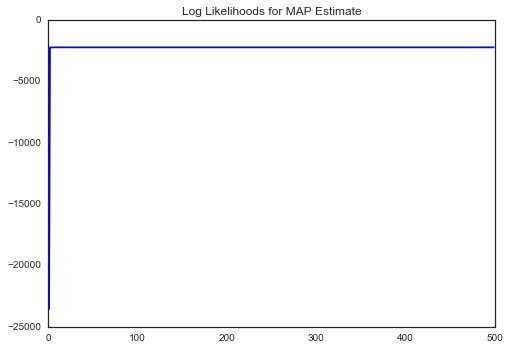

******************* MAP
mixture: [ 0.24950044  0.25039676  0.24992125  0.25018154]
mu [[  4.95245664   4.8298187    4.77301257]
 [  0.10029508   0.1060148   -0.12391181]
 [ 14.9701112   15.19394934  15.09144901]
 [  9.9175809    9.79985997   9.92982303]]
Sigma: [[ 0.9927167   0.02387311  0.10161109]
 [ 0.02387311  1.01786462  0.00926604]
 [ 0.10161109  0.00926604  0.89521642]]
Sigma: [[ 0.97501379 -0.0686599   0.1023066 ]
 [-0.0686599   0.89394471 -0.0201922 ]
 [ 0.1023066  -0.0201922   0.88309614]]


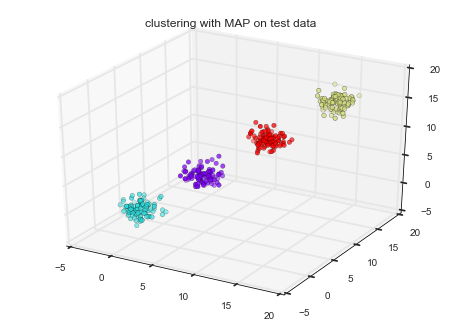

In [20]:
########################################
########################################
#####     Run on test data         #####
########################################
########################################

#-------------   run parameters
iters = 500

#-------------   test data parameters
K = 4 #number of components
N = 400 #number of observations
D = 3 #number of attributes per observation

data = test_data(N, D, 4, 5) #make test data



#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 4 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]


#---------------- MLE ----------------#
pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters, diag=True)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data, r, K, 'clustering with MLE on test data')

#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = np.eye(D)
nu_0 = D + 1

pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters, diag=True)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data, r, K, 'clustering with MAP on test data')


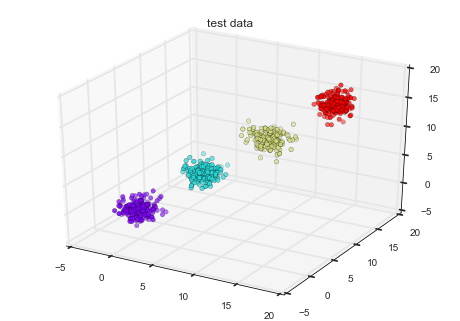

2
3
4
5
6


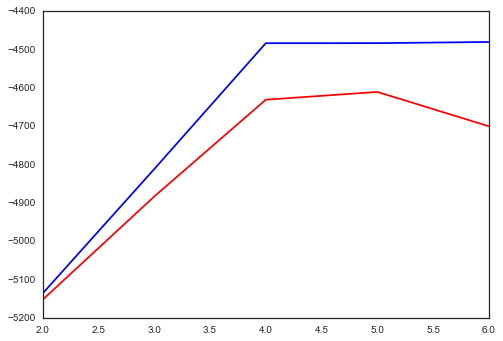

In [42]:
#-------------   test data parameters
K = 4 #number of components
N = 400 #number of observations
D = 3 #number of attributes per observation

data = test_data(N, D, 4, 5) #make test data

def model_comparison(K_max, data, iters, D, N):
    MLE_bic =[]
    MAP_bic = []
    for K in xrange(2, K_max + 1):
        #initialization of parameters
        print K
        pi = np.array([1./K] * K)
        mu_ind = np.random.randint(len(data), size=K)
        mu = np.asarray([data[mu_ind[k], :] for k in xrange(K)])
        Sigma = [100. * np.eye(D) for k in xrange(K)] 
        
        pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters)
        
        MLE_bic.append(bic(N, D, K, data, pi, mu, Sigma))
        #random initialization of hyperparameters
        alpha_0 = np.random.random(K)
        beta_0 = np.random.random()
        m_0 = np.zeros(D)
        S_0 = 100 * np.eye(D)
        nu_0 = D + 1

        pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)
        MAP_bic.append(bic(N, D, K, data, pi, mu, Sigma))
        
    plt.plot(range(2, len(MLE_bic) + 2), MLE_bic, color='b')
    plt.plot(range(2, len(MAP_bic) + 2), MAP_bic, color='r')
    
    plt.show()
    
model_comparison(6, data, 500, 3, data.shape[0]) 

## III. 311 Data: By Constituent Call

In [123]:
########################################
########################################
#####     Standardizing Data       #####
########################################
########################################
D = 3
call_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Constituent Call', 'OPEN_DT', random=True)[::5, :]
app_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Citizens Connect App', 'OPEN_DT', random=True)[::2, :]


data = np.vstack((call_data[:, :-1], app_data[:, :-1]))
mean = data.mean(axis=0)
std = data.std(axis=0)
print 'mean', mean
print 'std', std

for d in range(D):
    call_data[:, d] = (call_data[:, d] - mean[d]) / std[d]
    app_data[:, d] = (app_data[:, d] - mean[d]) / std[d]



mean [ 18833.88387047    -71.08242544     42.32936543]
std [  4.14431344e+04   3.42941562e-02   3.26839428e-02]


### Plot Data and Run K-means

(20406, 3)


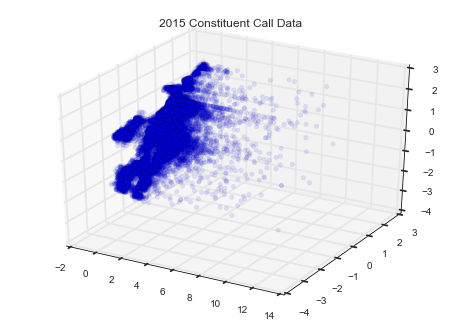

******************* K-means
mixture: [ 0.51489758  0.44687837  0.03822405]
mu [[-0.15647993 -0.69773494 -0.94614482]
 [-0.15374454  0.65099111  0.62314926]
 [ 3.91995952 -0.01850261 -0.08413797]]
Sigma: [[ 2286.14563025   446.79812027   213.53094082]
 [  446.79812027  9398.75860585  -926.25865909]
 [  213.53094082  -926.25865909  7389.22279741]]
Sigma: [[ 2167.18986702    46.83206143   -74.81372667]
 [   46.83206143  2497.63236711   863.44763854]
 [  -74.81372667   863.44763854  3141.42667433]]
Sigma: [[ 2744.30081026    36.42891253   -27.02306518]
 [   36.42891253   735.07577493   344.86671729]
 [  -27.02306518   344.86671729   747.1420423 ]]


In [108]:
########################################
########################################
#####     Run on call data         #####
########################################
########################################
data = call_data[:, :-1]
print data.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.title('2015 Constituent Call Data')


ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', alpha=0.1)
plt.show()

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 3 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
print 'Sigma:', Sigma[2]


### Selection of Number of Components

2
3
4
5
6


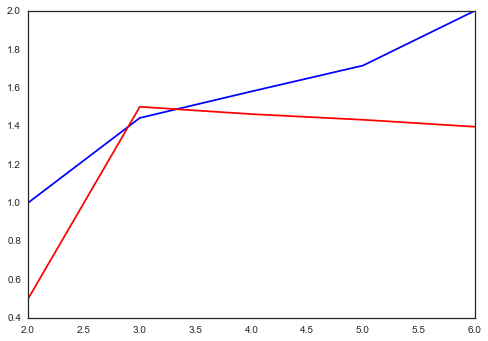

In [96]:
N = data.shape[0] #number of observations
D = data.shape[1] #number of features per observation

def model_comparison(K_max, data, iters):
    MLE_bic =[]
    MAP_bic = []
    for K in xrange(2, K_max + 1):
        #initialization of parameters
        print K
        pi = np.array([1./K] * K)
        mu_ind = np.random.randint(len(data), size=K)
        mu = np.asarray([data[mu_ind[k], :] for k in xrange(K)])
        Sigma = [100. * np.eye(D) for k in xrange(K)] 
        
        pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters)
        
        MLE_bic.append(bic(N, D, K, data, pi, mu, Sigma))
        #random initialization of hyperparameters
        alpha_0 = np.random.random(K)
        beta_0 = np.random.random()
        m_0 = np.zeros(D)
        S_0 = 1000. * np.eye(D)
        nu_0 = D + 1

        pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)
        MAP_bic.append(bic(N, D, K, data, pi, mu, Sigma))
    MLE_bic = np.asarray(MLE_bic)  
    MAP_bic = np.asarray(MAP_bic)   
    plt.plot(range(2, len(MLE_bic) + 2), (MLE_bic -  min(MLE_bic)) / (max(MLE_bic) - min(MLE_bic)) + 1, color='b')
    plt.plot(range(2, len(MAP_bic) + 2), (MAP_bic - min(MAP_bic)) / (max(MAP_bic) - min(MAP_bic)) + 0.5, color='r')
    
    plt.show()
    
model_comparison(6, data, 100)

### Point Estimates

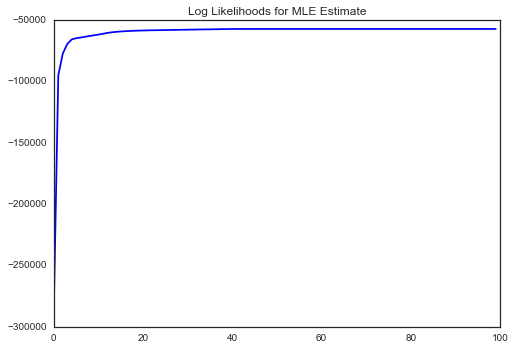

******************* MLE
mixture: [ 0.46015406  0.308623    0.23122294]
mu [[-0.28335778 -0.2504487  -0.29715878]
 [-0.44246949  0.12654292 -0.13654584]
 [ 1.158641    0.03086189 -0.14282435]]
Sigma: [[ 0.01679325  0.03075969 -0.00151575]
 [ 0.03075969  1.28240715  0.496357  ]
 [-0.00151575  0.496357    1.19754743]]
Sigma: [[  1.79268336e-04  -1.06701848e-03  -1.76566483e-03]
 [ -1.06701848e-03   7.54550262e-01   6.22113782e-01]
 [ -1.76566483e-03   6.22113782e-01   1.16596683e+00]]
Sigma: [[ 2.36866633 -0.0119975   0.03632225]
 [-0.0119975   0.87392257  0.37532975]
 [ 0.03632225  0.37532975  0.97480469]]


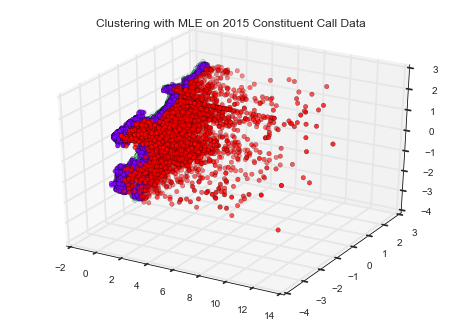

In [109]:
iters = 100

#---------------- Data parameters ----------------#
N = data.shape[0] #number of observations
K =3 #number of components
D = data.shape[1] #number of features per observation


#---------------- MLE ----------------#

#initialization of parameters
pi = np.array([1./K] * K)
#mu_ind = np.random.randint(len(data_std), size=K)
#mu = np.asarray([data[mu_ind[k], :] for k in xrange(K)])

#Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MLE estimate
pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters, diag=True)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
print 'Sigma:', Sigma[2]

#plot the components
plot_clusters(data, r, K, 'Clustering with MLE on 2015 Constituent Call Data')

savemat('2015_data_const_r_MLE.mat', {'r': r})

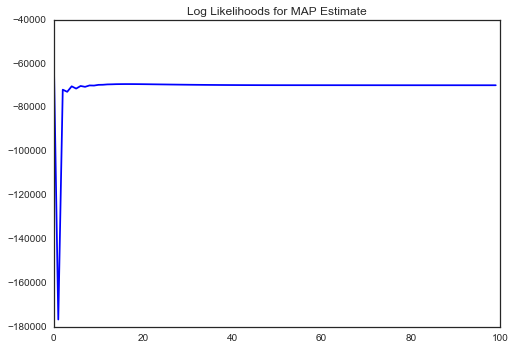

******************* MAP
mixture: [ 0.13795177  0.85561417  0.00643406]
mu [[  1.44914839e+00   5.81729345e-03  -1.00870066e-01]
 [ -2.85596910e-01  -8.06180353e-02  -2.30132447e-01]
 [  7.00437911e+00  -1.35817042e-01  -1.67447475e-01]]
Sigma: [[ 1.92483963  0.06452807  0.0097768 ]
 [ 0.06452807  1.28456653  0.29894916]
 [ 0.0097768   0.29894916  1.28388214]]
Sigma: [[ 0.109255    0.00936383 -0.00547017]
 [ 0.00936383  1.12566872  0.55098458]
 [-0.00547017  0.55098458  1.22771629]]
Sigma: [[ 10.56069314   0.4418922    0.16616875]
 [  0.4418922    8.54962789   0.88448615]
 [  0.16616875   0.88448615   8.52842064]]


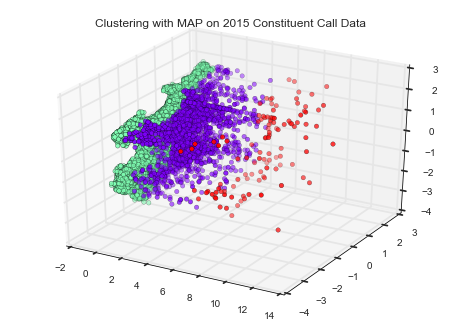

In [110]:
iters = 100
#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = 1000 * np.eye(D)
nu_0 = D + 1

#initialization of parameters
#pi = np.array([1./K] * K)
#mu_ind = np.random.randint(len(data), size=K)
#mu = np.asarray([data[mu_ind[k]] for k in xrange(K)])
#Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MAP estimate
pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters, diag=True)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
print 'Sigma:', Sigma[2]
    
#plot the components
plot_clusters(data, r, K, 'Clustering with MAP on 2015 Constituent Call Data')

savemat('2015_data_const_r_MAP.mat', {'r': r})

## IV. 311 Data: Citizens Connect App

### Plot Data and Run K-means

(18473, 3)


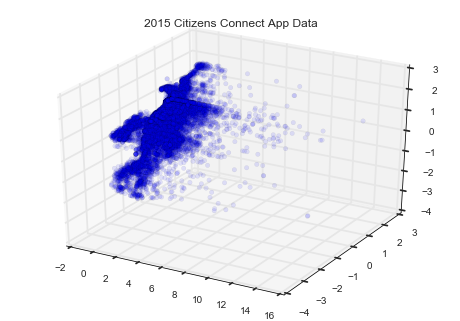

******************* K-means
mixture: [ 0.65230336  0.29903102  0.04866562]
mu [[-0.19181706  0.59831949  0.54441829]
 [-0.14626951 -1.06089784 -0.45402437]
 [ 3.44406063  0.06524917  0.30161632]]
Sigma: [[ 2617.45214917   -13.1460413     19.33355852]
 [  -13.1460413   2836.49627276   366.41571924]
 [   19.33355852   366.41571924  4481.79836596]]
Sigma: [[ 1335.45959078    10.28113184    41.17853411]
 [   10.28113184  3192.06324733  -979.1825434 ]
 [   41.17853411  -979.1825434   4802.59841846]]
Sigma: [[ 4044.99766005   -14.46437489  -121.01851882]
 [  -14.46437489   704.15896132   205.39721274]
 [ -121.01851882   205.39721274   572.47772603]]


In [111]:
########################################
########################################
#####      Run on app data         #####
########################################
########################################
data = app_data[:, :-1]
print data.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.title('2015 Citizens Connect App Data')


ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', alpha=0.1)
plt.show()

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 3 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
print 'Sigma:', Sigma[2]

### Selection of Number of Components

2
3
4
5
6


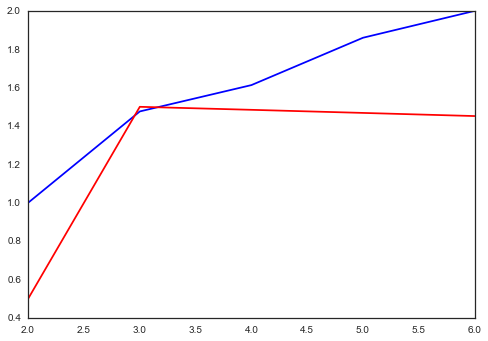

In [105]:
def model_comparison(K_max, data, iters):
    MLE_bic =[]
    MAP_bic = []
    for K in xrange(2, K_max + 1):
        #initialization of parameters
        print K
        pi = np.array([1./K] * K)
        mu_ind = np.random.randint(len(data), size=K)
        mu = np.asarray([data[mu_ind[k], :] for k in xrange(K)])
        Sigma = [100. * np.eye(D) for k in xrange(K)] 
        
        pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters)
        
        MLE_bic.append(bic(N, D, K, data, pi, mu, Sigma))
        #random initialization of hyperparameters
        alpha_0 = np.random.random(K)
        beta_0 = np.random.random()
        m_0 = np.zeros(D)
        S_0 = 1000. * np.eye(D)
        nu_0 = D + 1

        pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)
        MAP_bic.append(bic(N, D, K, data, pi, mu, Sigma))
    MLE_bic = np.asarray(MLE_bic)  
    MAP_bic = np.asarray(MAP_bic)   
    plt.plot(range(2, len(MLE_bic) + 2), (MLE_bic -  min(MLE_bic)) / (max(MLE_bic) - min(MLE_bic)) + 1, color='b')
    plt.plot(range(2, len(MAP_bic) + 2), (MAP_bic - min(MAP_bic)) / (max(MAP_bic) - min(MAP_bic)) + 0.5, color='r')
    
    plt.show()
    
model_comparison(6, data, 100)

### Point Estimates

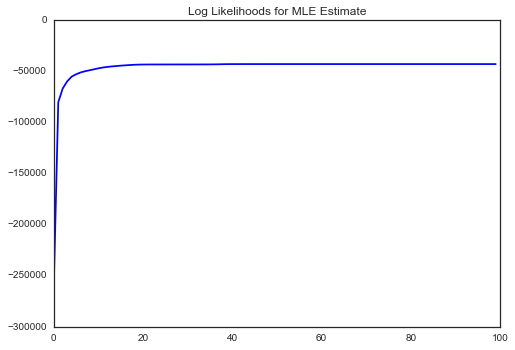

******************* MLE
mixture: [ 0.41469215  0.35609739  0.22921046]
mu [[-0.44490613  0.16361757  0.32587693]
 [-0.27773477  0.03635785  0.12411676]
 [ 1.23179095 -0.01970698  0.23882638]]
Sigma: [[  1.14369351e-04  -7.20829369e-04  -3.37002214e-04]
 [ -7.20829369e-04   8.76619390e-01   2.09404715e-01]
 [ -3.37002214e-04   2.09404715e-01   5.48272303e-01]]
Sigma: [[ 0.01833804  0.00753004  0.0090906 ]
 [ 0.00753004  0.95078186  0.45526454]
 [ 0.0090906   0.45526454  0.94488535]]
Sigma: [[ 2.51596723  0.08072088  0.003878  ]
 [ 0.08072088  0.96412119  0.27844906]
 [ 0.003878    0.27844906  0.72664814]]


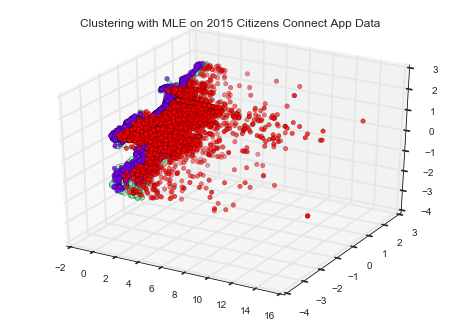

In [112]:
#---------------- MLE ----------------#
iters = 100

#initialization of parameters
pi = np.array([1./K] * K)
#mu_ind = np.random.randint(len(data_std), size=K)
#mu = np.asarray([data[mu_ind[k], :] for k in xrange(K)])

#Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MLE estimate
pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters, diag=True)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
print 'Sigma:', Sigma[2]

#plot the componentsplot_clusters(data, r, K, 'clustering with MLE on real Data')
plot_clusters(data, r, K, 'Clustering with MLE on 2015 Citizens Connect App Data')

savemat('2015_data_app_r_MLE.mat', {'r': r})

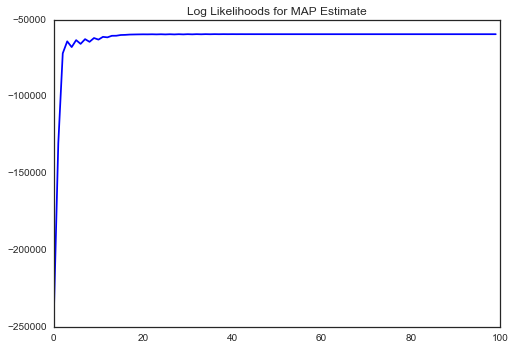

******************* MAP
mixture: [ 0.83150555  0.16061821  0.00787624]
mu [[-0.32005411  0.10147857  0.23575437]
 [ 1.28475424 -0.04635469  0.23087891]
 [ 7.34751927 -0.08100497  0.11962156]]
Sigma: [[ 0.1088711  -0.00862437 -0.00486507]
 [-0.00862437  0.96755996  0.32477091]
 [-0.00486507  0.32477091  0.79889581]]
Sigma: [[ 1.43729609  0.16179275  0.05837291]
 [ 0.16179275  1.36653982  0.26216304]
 [ 0.05837291  0.26216304  1.07216398]]
Sigma: [[ 11.86861284   0.47086945   0.20433425]
 [  0.47086945   7.49374592   0.58237359]
 [  0.20433425   0.58237359   7.50062468]]


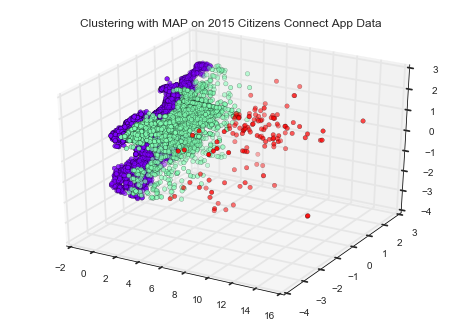

In [118]:
#---------------- MAP ----------------#
iters=100
#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = 1000. * np.eye(D)
nu_0 = D + 1

#initialization of parameters
#pi = np.array([1./K] * K)
#mu_ind = np.random.randint(len(data), size=K)
#mu = np.asarray([data[mu_ind[k]] for k in xrange(K)])
#Sigma = [1000. * np.eye(D) for k in xrange(K)] 


#run EM for MAP estimate
pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters, diag=True)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
print 'Sigma:', Sigma[2]
    
#plot the components
plot_clusters(data, r, K, 'Clustering with MAP on 2015 Citizens Connect App Data')

savemat('2015_data_app_r_MAP.mat', {'r': r})

### Save Data

In [107]:
savemat('2015_data_by_open_const_std.mat', {'data': call_data})
savemat('2015_data_by_open_app_std.mat', {'data': app_data})

c_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Constituent Call', 'OPEN_DT')
savemat('2015_data_by_open_const.mat', {'data': c_data})

a_data = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                 'Citizens Connect App', 'OPEN_DT')

savemat('2015_data_by_open_app.mat', {'data': a_data})

savemat('2015_data_by_open.mat', {'data': np.vstack((a_data, c_data))})


depts = Counter(closed_requests['Department'])
depts = counter.keys()

print depts

by_dept = {}
for dept in depts:
    by_dept[dept] = real_data('January 01, 2015 12:00AM', 'January 01, 2016 12:00AM', 
                              'Constituent Call', 'OPEN_DT', dept=dept)
    
savemat('2015_data_by_dept_const.mat', by_dept)

print 'data saved'

['INFO', 'GEN_', 'BTDT', 'BWSC', 'BPS_', 'PARK', 'PROP', 'HS_O', 'DISB', 'ANML', 'PWDx', 'CHT_', 'ISD']
data saved


## Cluster Analysis

In [ ]:
#---------------- Plot Cluster Membership Histogram ----------------#

def filter_by_id(ids, k, source, col, N, ax, font_size):
    begin = pd.to_datetime('January 01, 2015 12:00AM') 
    end = pd.to_datetime('January 01, 2016 12:00AM')

    # Filter for requests opened between begin and end dates
    in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
    in_range = in_range[in_range['OPEN_DT'] < end]

    # Filter for requests with specific source
    in_range = in_range[in_range['Source'] == source]
    
    depts = Counter(in_range[col])
    keys = depts.keys()
    
    # Filter for requests for a set of case ids
    in_range = in_range[in_range['CASE_ENQUIRY_ID'].isin(ids)]
    
    counter = Counter(in_range[col])    
    dept_keys = counter.keys()
    dept_counts = counter.values()

    indexes = np.arange(len(dept_keys))
    width = 0.7

    values = np.linspace(0, 1, len(keys))
    cm = plt.get_cmap('rainbow') 
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    colorVal = scalarMap.to_rgba([values[keys.index(key)] for key in dept_keys])

    ax.bar(indexes, dept_counts, width, color=colorVal)
    ax.set_xticks(indexes + width * 0.5)
    ax.set_xticklabels(dept_keys)
    labels = ax.get_xticklabels() 
    for label in labels: 
        label.set_fontsize(font_size) 
        label.set_rotation(50) 
    ax.set_ylim(0, )
    ax.set_title('Cluster ' + str(k) + ', Size ' + str(N) + ', Request Volume by ' + col + ' (' + source + ', MAP)', fontsize=20)

### Cluster Profiles for Citizens Connect App Data

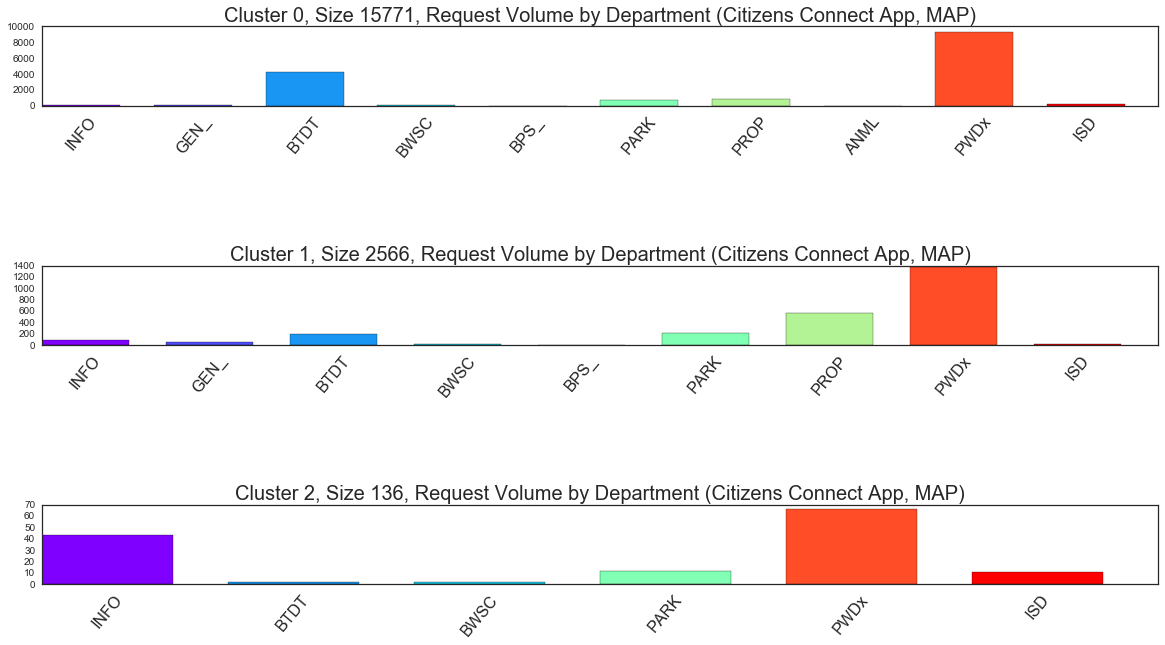

In [207]:
#---------------- Plot Cluster Membership Histogram: By Department ----------------#

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=2)
ax1 = fig.add_subplot(3,1,1)
ids = loadmat('2015_data_app_MAP_ids.mat')['0'].tolist()
ids = ids[0]
filter_by_id(ids, 0, 'Citizens Connect App', 'Department', len(ids), ax1, 16)
ax2 = fig.add_subplot(3,1,2)
ids = loadmat('2015_data_app_MAP_ids.mat')['1'].tolist()
ids = ids[0]
filter_by_id(ids, 1, 'Citizens Connect App', 'Department', len(ids), ax2, 16)
ax3 = fig.add_subplot(3,1,3)
ids = loadmat('2015_data_app_MAP_ids.mat')['2'].tolist()
ids = ids[0]

filter_by_id(ids, 2, 'Citizens Connect App', 'Department', len(ids), ax3, 16)

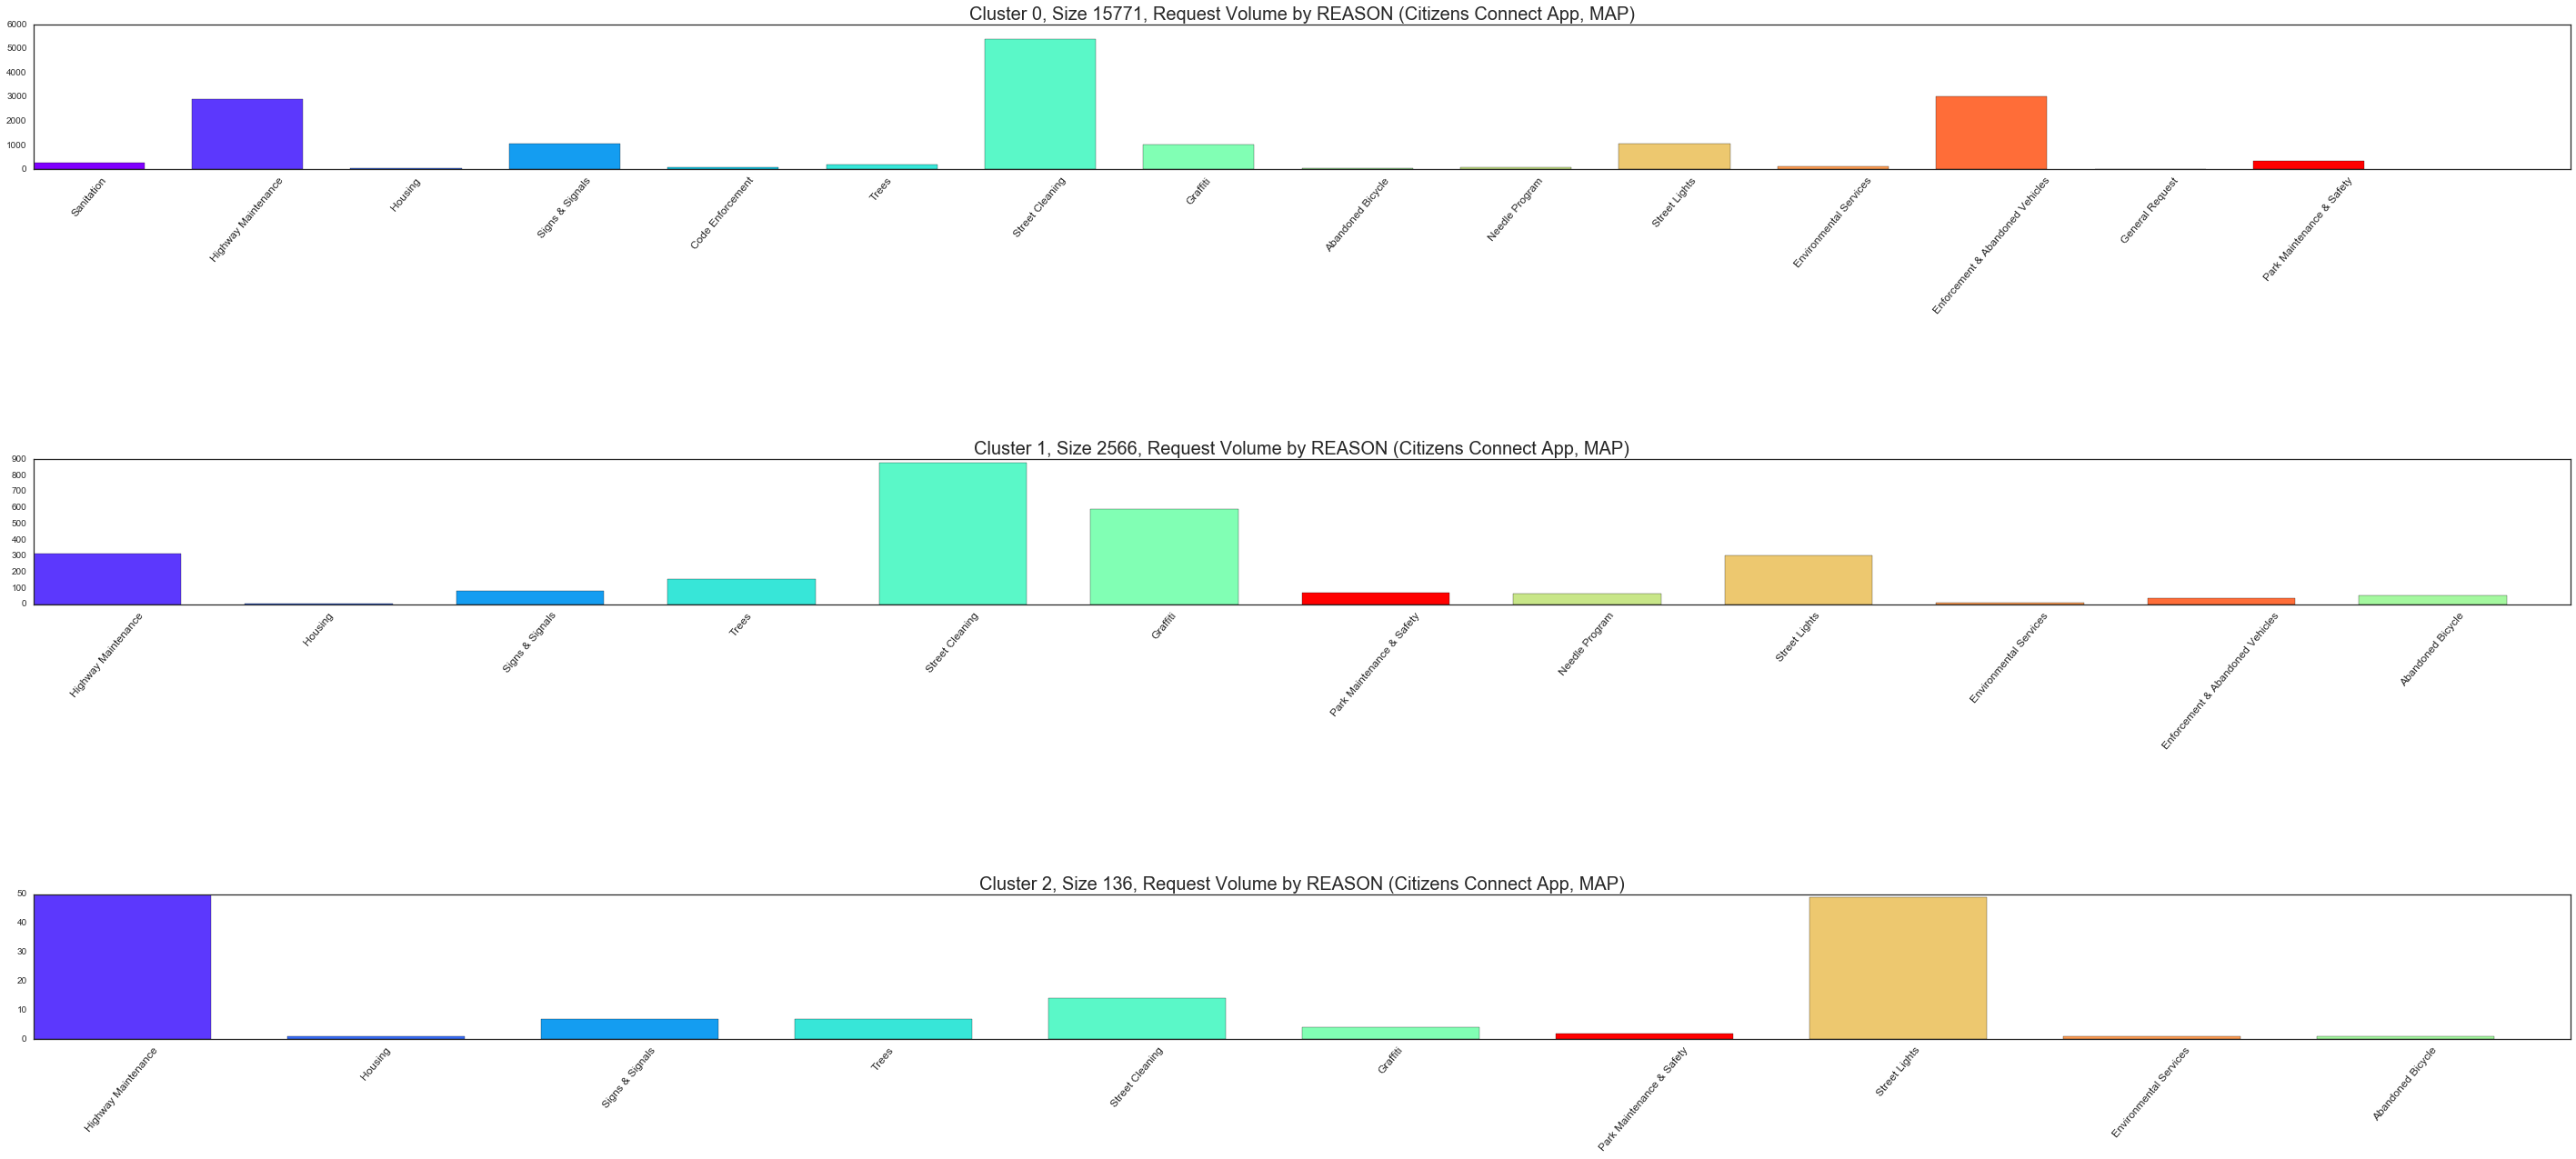

In [186]:
#---------------- Plot Cluster Membership Histogram: By Reason ----------------#

fig = plt.figure(figsize=(50, 20))
fig.subplots_adjust(hspace=2)
ax1 = fig.add_subplot(3,1,1)
ids = loadmat('2015_data_app_MAP_ids.mat')['0'].tolist()
ids = ids[0]
filter_by_id(ids, 0, 'Citizens Connect App', 'REASON', len(ids), ax1, 12)
ax2 = fig.add_subplot(3,1,2)
ids = loadmat('2015_data_app_MAP_ids.mat')['1'].tolist()
ids = ids[0]

filter_by_id(ids, 1, 'Citizens Connect App', 'REASON', len(ids), ax2, 12)
ax3 = fig.add_subplot(3,1,3)
ids = loadmat('2015_data_app_MAP_ids.mat')['2'].tolist()
ids = ids[0]

filter_by_id(ids, 2, 'Citizens Connect App', 'REASON', len(ids), ax3, 12)


### Cluster Profiles for Constituent Call Data

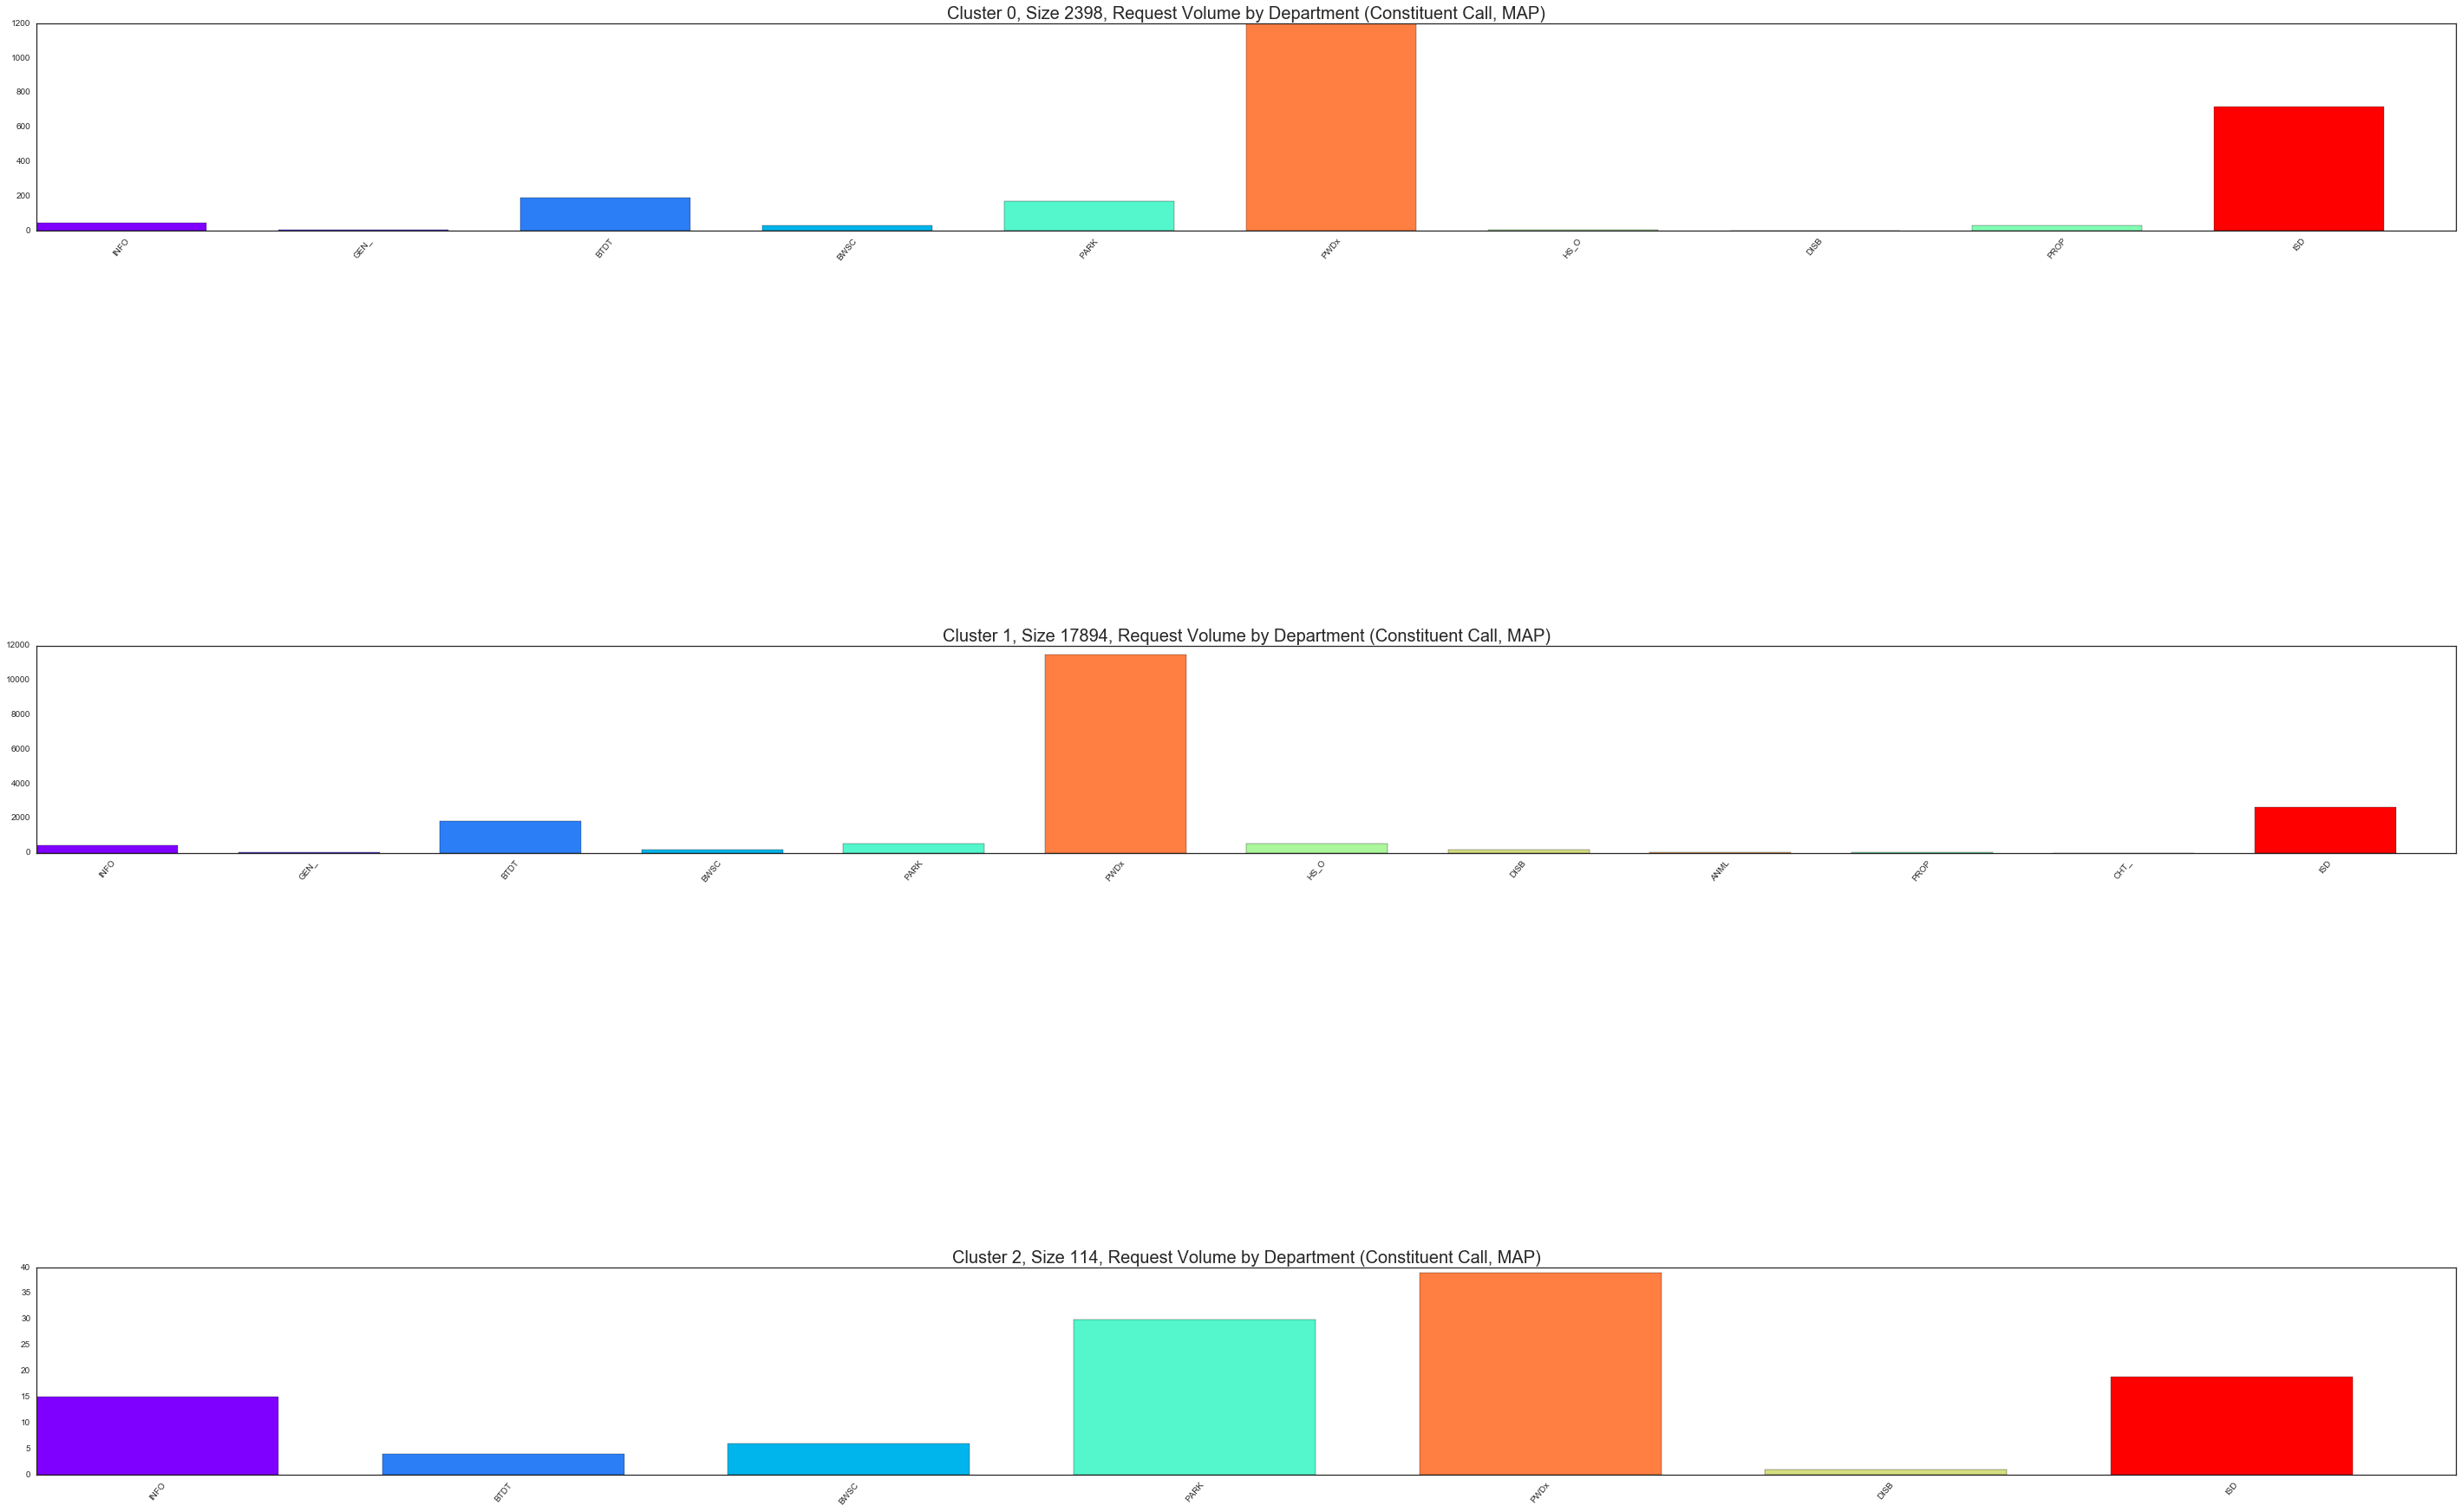

In [187]:
#---------------- Plot Cluster Membership Histogram: By Department ----------------#

fig = plt.figure(figsize=(50, 30))
fig.subplots_adjust(hspace=2)
ax1 = fig.add_subplot(3,1,1)
ids = loadmat('2015_data_const_MAP_ids.mat')['0'].tolist()
ids = ids[0]
filter_by_id(ids, 0, 'Constituent Call', 'Department', len(ids), ax1, 10)
ax2 = fig.add_subplot(3,1,2)
ids = loadmat('2015_data_const_MAP_ids.mat')['1'].tolist()
ids = ids[0]

filter_by_id(ids, 1, 'Constituent Call', 'Department', len(ids), ax2, 10)
ax3 = fig.add_subplot(3,1,3)
ids = loadmat('2015_data_const_MAP_ids.mat')['2'].tolist()
ids = ids[0]

filter_by_id(ids, 2, 'Constituent Call', 'Department', len(ids), ax3, 10)

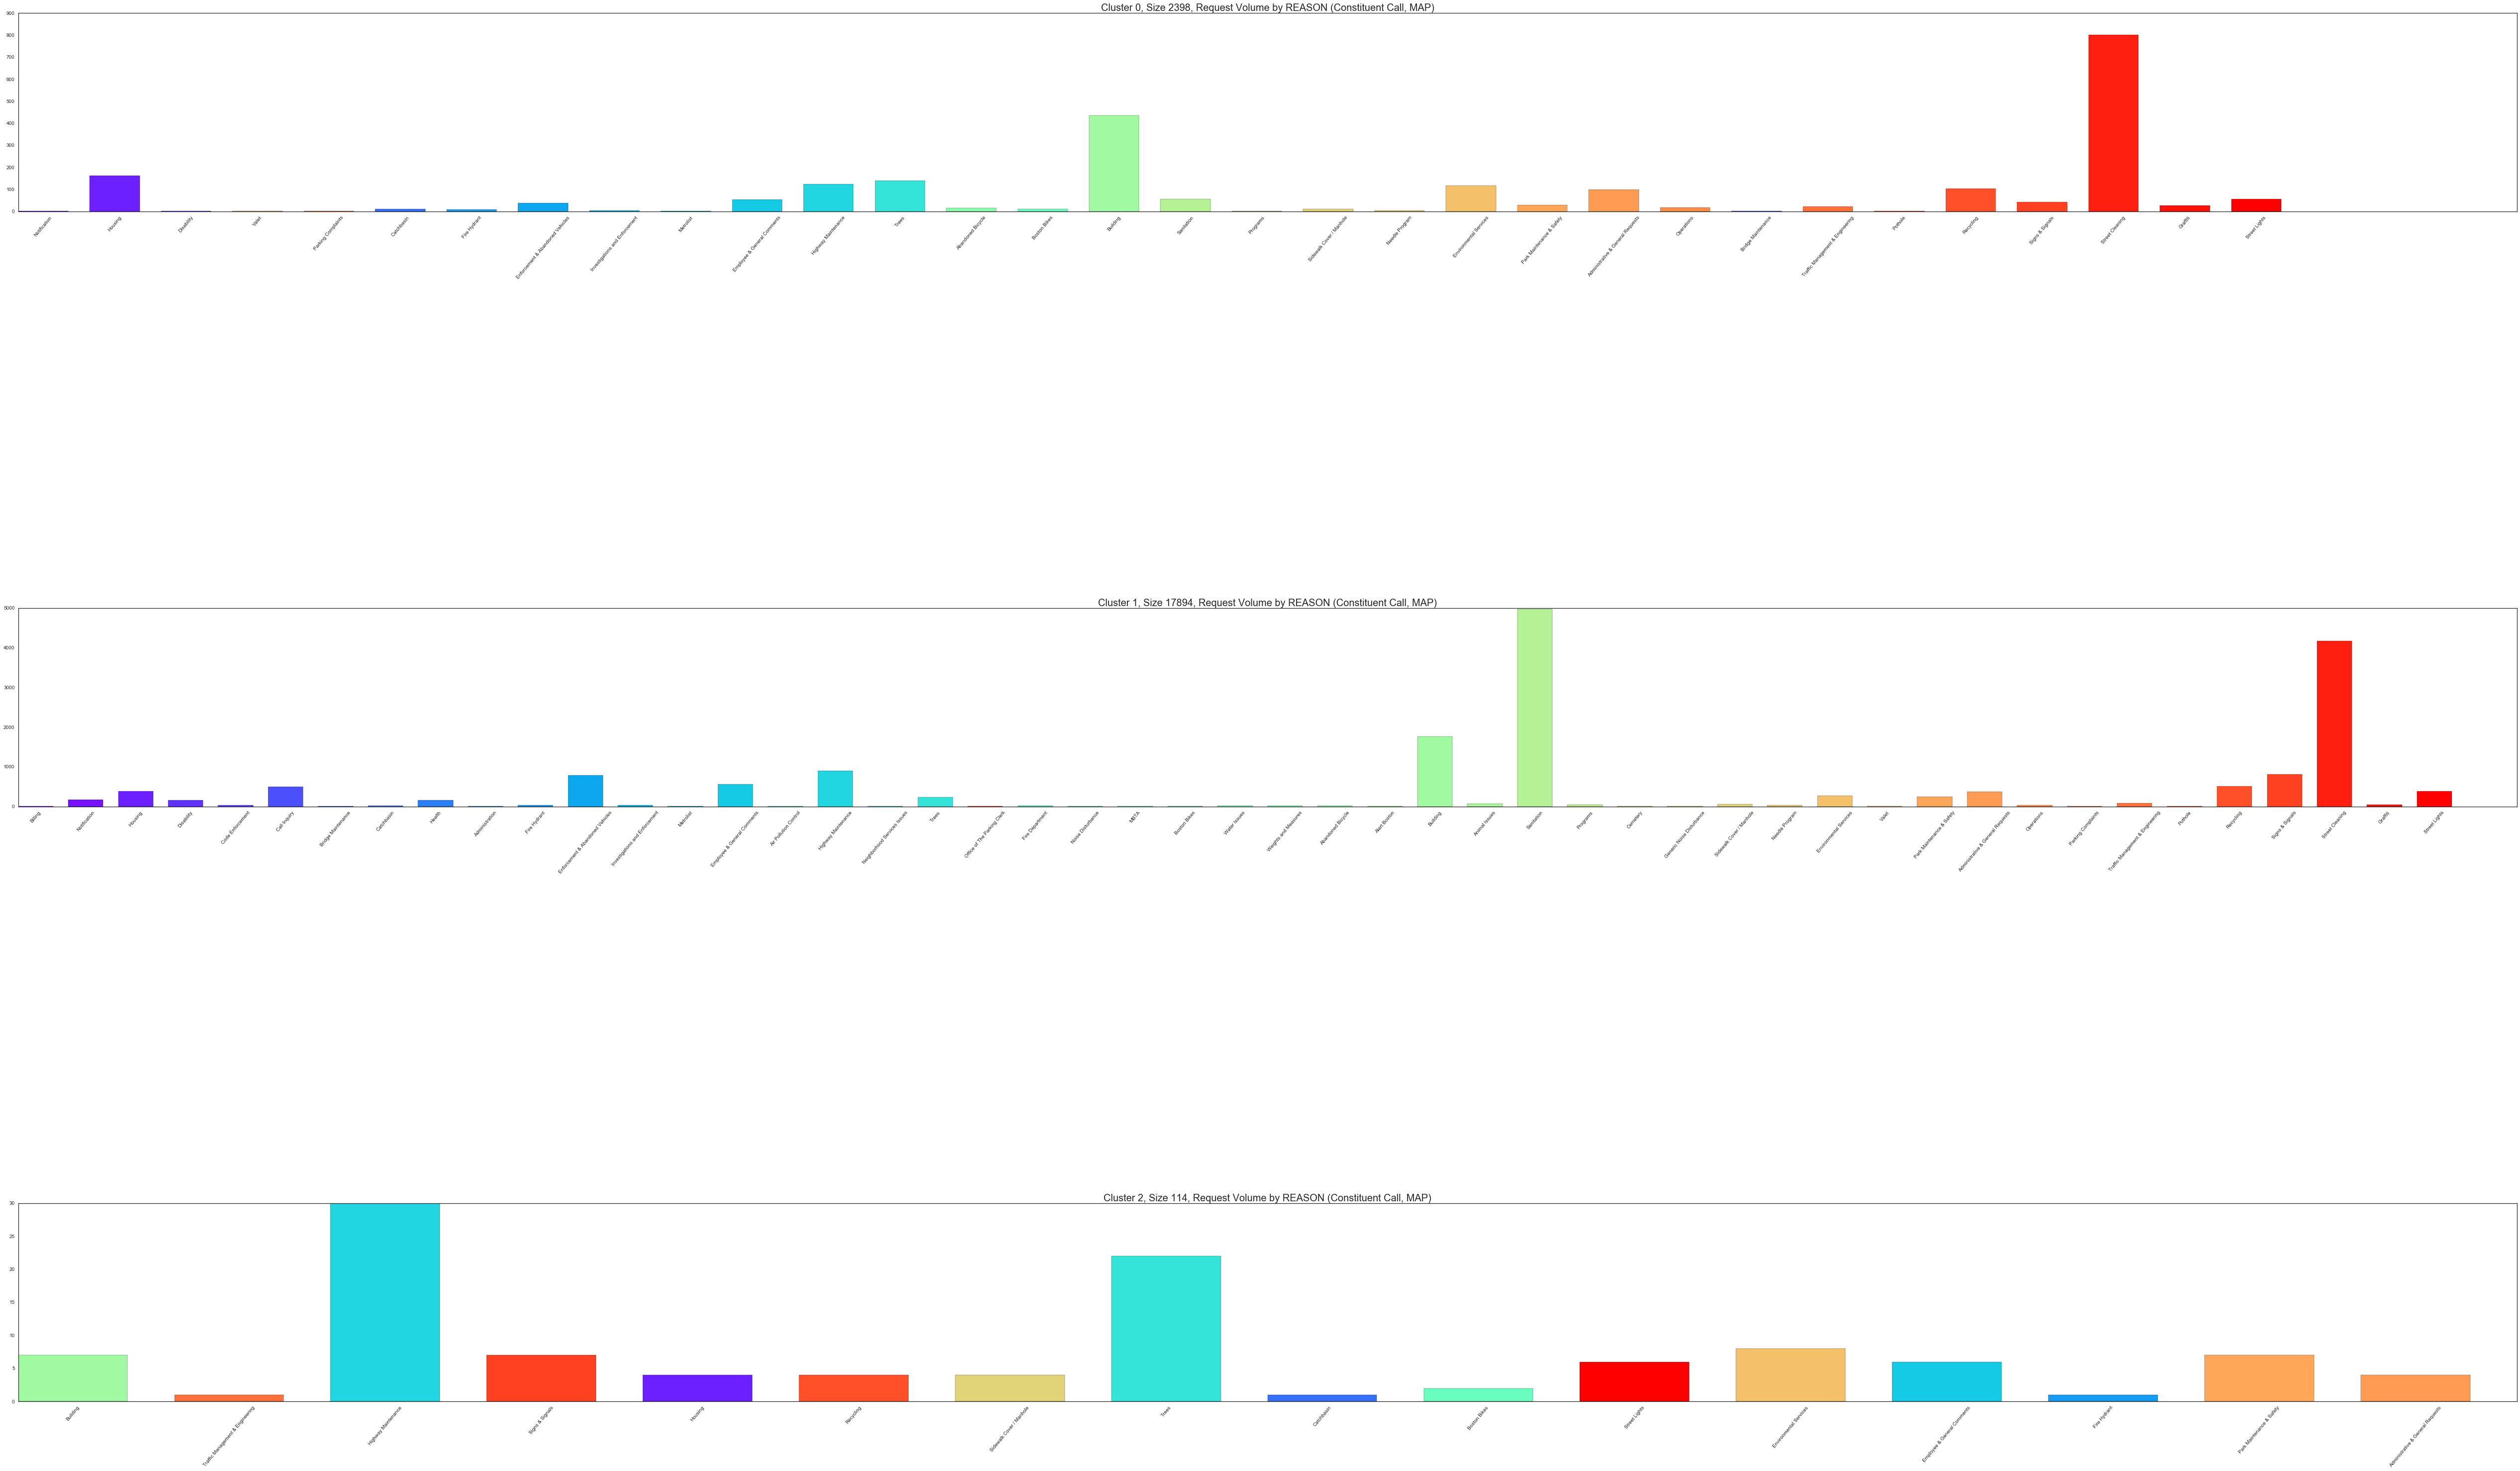

In [208]:
#---------------- Plot Cluster Membership Histogram: By Reason ----------------#

fig = plt.figure(figsize=(90, 50))
fig.subplots_adjust(hspace=2)
ax1 = fig.add_subplot(3,1,1)
ids = loadmat('2015_data_const_MAP_ids.mat')['0'].tolist()
ids = ids[0]
filter_by_id(ids, 0, 'Constituent Call', 'REASON', len(ids), ax1, 10)
ax2 = fig.add_subplot(3,1,2)
ids = loadmat('2015_data_const_MAP_ids.mat')['1'].tolist()
ids = ids[0]

filter_by_id(ids, 1, 'Constituent Call', 'REASON', len(ids), ax2, 10)
ax3 = fig.add_subplot(3,1,3)
ids = loadmat('2015_data_const_MAP_ids.mat')['2'].tolist()
ids = ids[0]

filter_by_id(ids, 2, 'Constituent Call', 'REASON', len(ids), ax3, 10)